# Nonlinear Model: Heating Rate with Dorsal & Finger Heating
Created by Yutaka Taro Kusumah, with help from ChatGPT for code implementation.
This notebook fits an exponential heating model:

### Model:
$$ T(t) = T_0 + A (1 - e^{-k t}) $$
Where:
$$ k = b_0 + b_1 \cdot \text{dorsal} + b_2 \cdot \text{finger} + b_3 \cdot (\text{dorsal} \cdot \text{finger}) $$

The goal is to estimate $b_0$ through $b_3$ and test their **p-values** for statistical significance.

In [1]:
# Step 1: Import libraries
import os
import numpy as np
import pandas as pd
!pip install lmfit
from lmfit import Model
import matplotlib.pyplot as plt
from scipy.stats import norm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.7/97.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 2.5 MB/s eta 0:00:00


Then, we can load the dataset.

In [2]:
PATH = "/kaggle/input/dorsal-temp-under-varying-heating-gloves-config/Research_Project.csv"
df_raw = pd.read_csv(PATH)
df_raw

,Time,Dorsal,Finger,Both,None
0,0,36.125,36.125,36.175,36.025
1,2,36.900,36.775,36.875,36.025
2,4,37.075,36.800,36.975,36.000
3,6,37.650,36.900,37.300,36.050
4,8,37.575,37.050,37.350,36.275
5,10,37.825,37.150,37.500,36.025
6,12,37.825,37.325,37.625,36.125
7,14,38.000,37.225,37.650,36.075
8,16,38.125,37.250,37.725,36.025
9,18,38.650,37.450,38.050,36.100


We want such that dorsal heating and finger heating is treated as separate categories, with the added binary category "Synergy" that is True when both dorsal and finger heating is present. So we need to reshape the data table.

In [3]:
df = df_raw.melt(id_vars="Time", var_name="Placement", value_name="Temp")
df["dorsal_"] = df["Placement"].isin(["Dorsal", "Both"]).astype(int)
df["finger_"] = df["Placement"].isin(["Finger", "Both"]).astype(int)
df["inter_"] = df["dorsal_"] * df["finger_"]
df

,Time,Placement,Temp,dorsal_,finger_,inter_
0,0,Dorsal,36.125,1,0,0
1,2,Dorsal,36.900,1,0,0
2,4,Dorsal,37.075,1,0,0
3,6,Dorsal,37.650,1,0,0
4,8,Dorsal,37.575,1,0,0
5,10,Dorsal,37.825,1,0,0
6,12,Dorsal,37.825,1,0,0
7,14,Dorsal,38.000,1,0,0
8,16,Dorsal,38.125,1,0,0
9,18,Dorsal,38.650,1,0,0


Then, define the exponential model, k: the rate of heating, which is assumed to be exponentially as the heating should slow down the higher the skin temperature is.

In [4]:
def model_k_varies(t, T0, A, B0, B1, B2, B3, dorsal_, finger_, inter_):
    k = B0 + B1 * dorsal_ + B2 * finger_ + B3 * inter_
    return T0 + A * (1 - np.exp(-k * t))

Now, fit the model using lmfit.

In [5]:
# Fit model
model = Model(
    model_k_varies,
    independent_vars=["t", "dorsal_", "finger_", "inter_"]
)

T0_init = df["Temp"].min()
A_init = df["Temp"].max() - df["Temp"].min()

params = model.make_params(
    T0=T0_init, A=A_init,
    B0=0.05, B1=0.01, B2=0.01, B3=0.01
)
params["B0"].set(min=None)
params["B1"].min = -0.05
params["B2"].min = -0.05
params["B3"].min = -0.05

# Run the fit — this must now work
result = model.fit(
    df["Temp"],
    params,
    t=df["Time"].values,
    dorsal_=df["dorsal_"].values,
    finger_=df["finger_"].values,
    inter_=df["inter_"].values
)

In [6]:
for name, param in result.params.items():
    print(f"{name}: {param.value} ± {param.stderr}")

T0: 36.301088741755265 ± 0.05705362186972385
A: 3.0192439565534777 ± 0.2546760751964051
B0: -0.004639653917922029 ± 0.0018397060775852834
B1: 0.07036472707697228 ± 0.00877598871225104
B2: 0.033876756770120364 ± 0.0038082463348219865
B3: -0.049999999943088014 ± 0.008128885870289957


In [7]:
for name, param in result.params.items():
    hit_min = (param.min is not None) and (np.isclose(param.value, param.min))
    hit_max = (param.max is not None) and (np.isclose(param.value, param.max))
    print(f"{name}: {param.value}, stderr: {param.stderr}, at lower bound: {hit_min}, at upper bound: {hit_max}")

T0: 36.301088741755265, stderr: 0.05705362186972385, at lower bound: False, at upper bound: False
A: 3.0192439565534777, stderr: 0.2546760751964051, at lower bound: False, at upper bound: False
B0: -0.004639653917922029, stderr: 0.0018397060775852834, at lower bound: False, at upper bound: False
B1: 0.07036472707697228, stderr: 0.00877598871225104, at lower bound: False, at upper bound: False
B2: 0.033876756770120364, stderr: 0.0038082463348219865, at lower bound: False, at upper bound: False
B3: -0.049999999943088014, stderr: 0.008128885870289957, at lower bound: True, at upper bound: False


To show the fit report, we will use this following code.

In [8]:
# Output
print(result.fit_report())

[[Model]]
    Model(model_k_varies)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 203
    # data points      = 44
    # variables        = 6
    chi-square         = 1.12338889
    reduced chi-square = 0.02956287
    Akaike info crit   = -149.384948
    Bayesian info crit = -138.679810
    R-squared          = 0.95687943
[[Variables]]
    T0:  36.3010887 +/- 0.05705362 (0.16%) (init = 36)
    A:   3.01924396 +/- 0.25467608 (8.44%) (init = 2.65)
    B0: -0.00463965 +/- 0.00183971 (39.65%) (init = 0.05)
    B1:  0.07036473 +/- 0.00877599 (12.47%) (init = 0.01)
    B2:  0.03387676 +/- 0.00380825 (11.24%) (init = 0.01)
    B3: -0.05000000 +/- 0.00812889 (16.26%) (init = 0.01)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, B1)  = -0.8778
    C(B1, B3) = +0.7749
    C(A, B2)  = -0.7208
    C(B1, B2) = +0.6984
    C(T0, B0) = -0.6842
    C(B2, B3) = +0.6718
    C(A, B3)  = -0.5919
    C(T0, B1) = -0.3063
    C(T0, B3) = -0.2870
    C(T0, B2) = -

To turn this into a more readable table, we can use:

In [9]:
summary = []
for name, p in result.params.items():
    estimate = p.value
    stderr = p.stderr if p.stderr else np.nan
    tval = estimate / stderr if stderr else np.nan
    pval = 2 * (1 - norm.cdf(abs(tval))) if not np.isnan(tval) else np.nan
    
    summary.append({
        "Parameter": name,
        "Estimate": round(estimate, 5),
        "Std Error": round(stderr, 5) if not np.isnan(stderr) else None,
        "t-value": round(tval, 3) if not np.isnan(tval) else None,
        "p-value": f"{pval:.4f}" if not np.isnan(pval) else None,
        "Rel Error (%)": round(100 * stderr / abs(estimate), 2) if stderr and estimate else None
    })

results_df = pd.DataFrame(summary)
print("📄 Fit Summary Table with p-values:")
display(results_df)

📄 Fit Summary Table with p-values:


,Parameter,Estimate,Std Error,t-value,p-value,Rel Error (%)
0,T0,36.30109,0.05705,636.263,0.0000,0.16
1,A,3.01924,0.25468,11.855,0.0000,8.44
2,B0,-0.00464,0.00184,-2.522,0.0117,39.65
3,B1,0.07036,0.00878,8.018,0.0000,12.47
4,B2,0.03388,0.00381,8.896,0.0000,11.24
5,B3,-0.05000,0.00813,-6.151,0.0000,16.26


Plotting time...

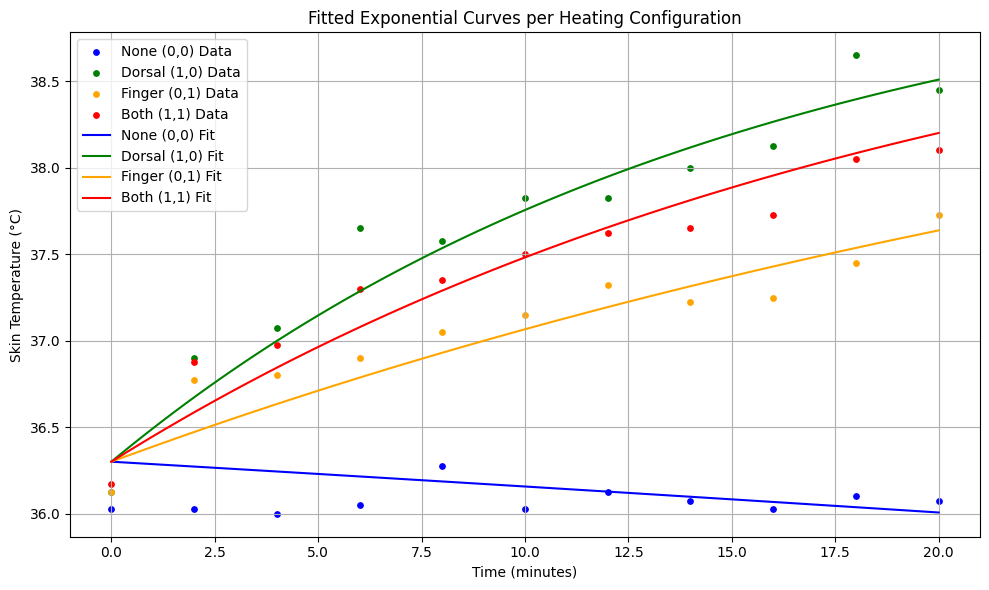

In [10]:
# Get model constants
T0 = result.params["T0"].value
A = result.params["A"].value
B0 = result.params["B0"].value
B1 = result.params["B1"].value
B2 = result.params["B2"].value
B3 = result.params["B3"].value

# Time range for smooth curve
t_range = np.linspace(0, 20, 100)

# Configurations and consistent colors
configs = {
    "None (0,0)": (0, 0),
    "Dorsal (1,0)": (1, 0),
    "Finger (0,1)": (0, 1),
    "Both (1,1)": (1, 1),
}
colors = {
    "None (0,0)": "blue",
    "Dorsal (1,0)": "green",
    "Finger (0,1)": "orange",
    "Both (1,1)": "red"
}

# Start plot
plt.figure(figsize=(10, 6))

# Plot data in same color as fit
for label, (d, f) in configs.items():
    color = colors[label]
    mask = (df["dorsal_"] == d) & (df["finger_"] == f)
    plt.scatter(df.loc[mask, "Time"], df.loc[mask, "Temp"], color=color, label=f"{label} Data", s=15)

# Plot exponential fit
for label, (d, f) in configs.items():
    color = colors[label]
    k = B0 + B1 * d + B2 * f + B3 * (d * f)
    T_fit = T0 + A * (1 - np.exp(-k * t_range))
    plt.plot(t_range, T_fit, color=color, label=f"{label} Fit")

plt.xlabel("Time (minutes)")
plt.ylabel("Skin Temperature (°C)")
plt.title("Fitted Exponential Curves per Heating Configuration")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now we try to make a plot for t=5, t=20, and t=60 minutes.

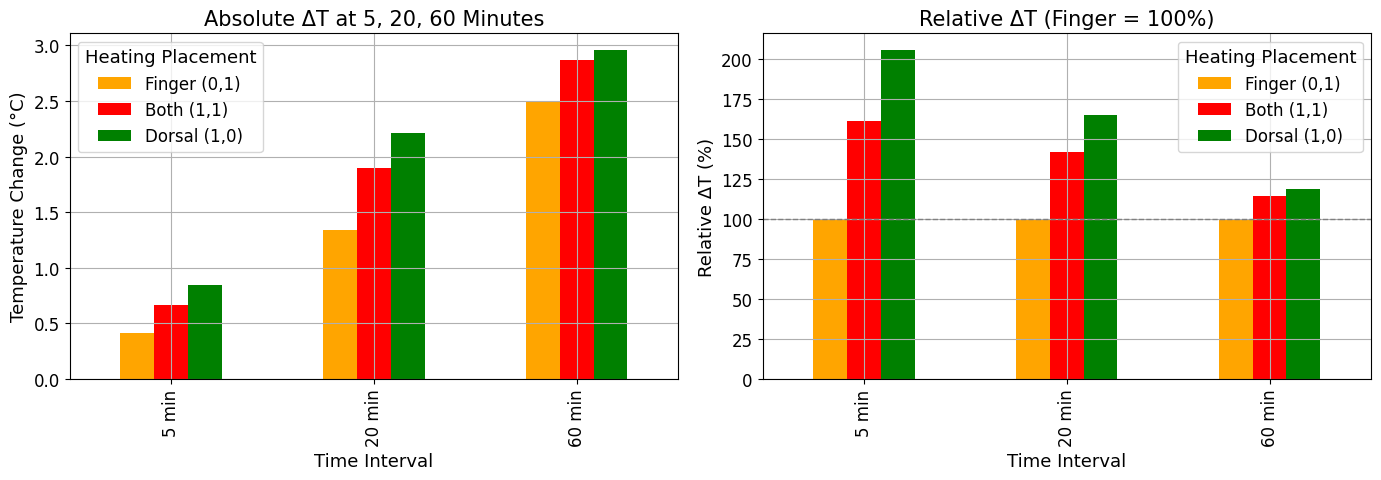

In [11]:
# Configurations and visual settings
evaluation_times = [5, 20, 60]
config_labels = ["Finger (0,1)", "Both (1,1)", "Dorsal (1,0)"]
configs = [(0, 1), (1, 1), (1, 0)]
color_map = {
    "Finger (0,1)": "orange",
    "Both (1,1)": "red",
    "Dorsal (1,0)": "green"
}

# ΔT Table (Absolute)
delta_T_table = pd.DataFrame(columns=["5 min", "20 min", "60 min"], index=config_labels)
for label, (d, f) in zip(config_labels, configs):
    k = B0 + B1 * d + B2 * f + B3 * d * f
    delta_T = [A * (1 - np.exp(-k * t)) for t in evaluation_times]
    delta_T_table.loc[label] = delta_T

# Relative Table (% of Finger)
relative_table = delta_T_table.copy()
for col in relative_table.columns:
    base = relative_table.loc["Finger (0,1)", col]
    relative_table[col] = (relative_table[col] / base) * 100

# Transpose for plotting
abs_T = delta_T_table.T
rel_T = relative_table.T

# Set global font sizes
plt.rcParams.update({
    'font.size': 13,
    'axes.titlesize': 15,
    'axes.labelsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 13
})

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# Plot 1: Absolute ΔT
abs_T.plot(kind="bar", ax=axes[0], color=[color_map[col] for col in abs_T.columns])
axes[0].set_title("Absolute ΔT at 5, 20, 60 Minutes")
axes[0].set_ylabel("Temperature Change (°C)")
axes[0].set_xlabel("Time Interval")
axes[0].legend(title="Heating Placement")
axes[0].grid(True)

# Plot 2: Relative ΔT
rel_T.plot(kind="bar", ax=axes[1], color=[color_map[col] for col in rel_T.columns])
axes[1].set_title("Relative ΔT (Finger = 100%)")
axes[1].set_ylabel("Relative ΔT (%)")
axes[1].set_xlabel("Time Interval")
axes[1].axhline(100, color="gray", linestyle="--", linewidth=1)
axes[1].legend(title="Heating Placement")
axes[1].grid(True)

plt.tight_layout()
plt.show()

The tables too.

In [12]:
# Reformat tables: rows = configs, columns = time
abs_table_final = delta_T_table.loc[["Finger (0,1)", "Both (1,1)", "Dorsal (1,0)"]]
abs_table_final.index = ["Finger", "Both", "Dorsal"]

rel_table_final = relative_table.loc[["Finger (0,1)", "Both (1,1)", "Dorsal (1,0)"]]
rel_table_final.index = ["Finger", "Both", "Dorsal"]

# Display both tables
print("=== Absolute ΔT (°C) ===")
display(abs_table_final.round(3))

print("\n=== Relative ΔT (% of Finger) ===")
display(rel_table_final.round(1))

=== Absolute ΔT (°C) ===


,5 min,20 min,60 min
Finger,0.410625,1.336772,2.496791
Both,0.663168,1.899646,2.86529
Dorsal,0.845652,2.20825,2.96073



=== Relative ΔT (% of Finger) ===


,5 min,20 min,60 min
Finger,100.0,100.0,100.0
Both,161.50221,142.10699,114.758929
Dorsal,205.942636,165.192797,118.581445


We will also conduct a homoskedasticity, normality, and residuals normality tests/plots to be sure.

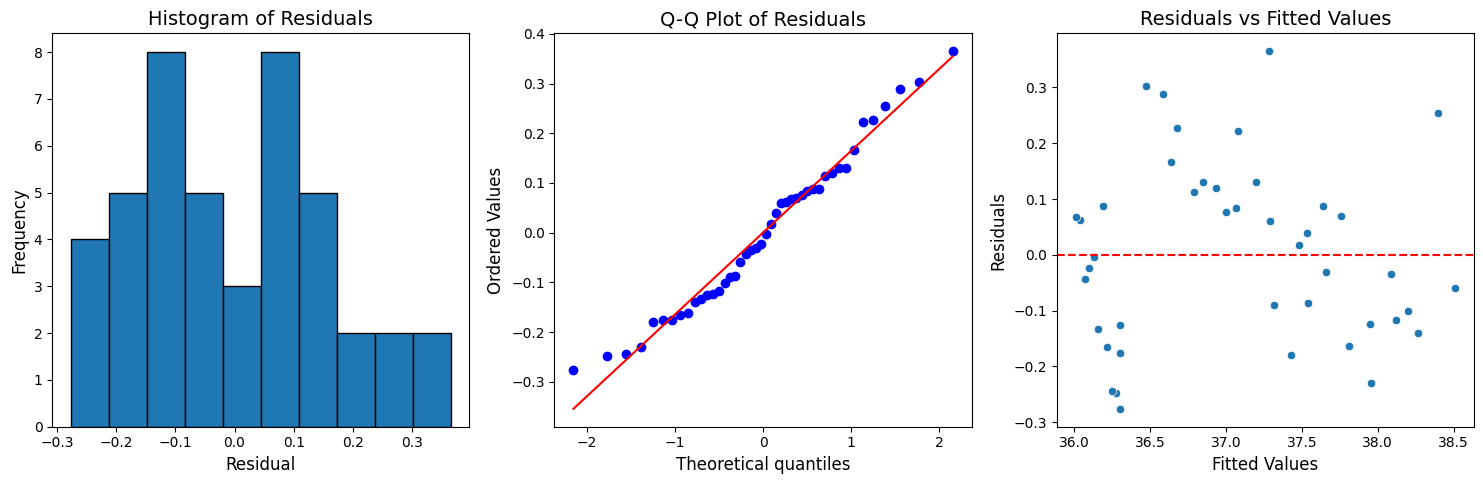

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

residuals = result.residual
fitted_vals = result.best_fit

# Update global font sizes
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 12
})

# Create wider figure to match full-width plot
plt.figure(figsize=(15, 5))  # 3:1 aspect ratio

# 1. Histogram
plt.subplot(1, 3, 1)
plt.hist(residuals, bins=10, edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")

# 2. Q-Q Plot
plt.subplot(1, 3, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")

# 3. Residuals vs Fitted
plt.subplot(1, 3, 3)
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()